In [3]:
import numpy as np
import matplotlib.pyplot as plt

# LabView in Arduino, Python

Kljub sicer zaprti strukturi je del LabView ekosistema tudi upravljanik paketov ["VI Package manager (VIPM)"](https://www.vipm.io/), kjer lahko uporabniki delijo LabView kodo in pakete, s katerimi je mogoča uporaba funkcionalnost in opreme, ki je sam LabView sicer ne podpira.

Za nekomercialno rabo je v istem sklopu na voljo tudi [LabView Community Edition](https://www.ni.com/sl-si/shop/labview/select-edition/labview-community-edition.html), ki omogoča brezplačn uporabo osnovnih funkcij LabView-a.

```{admonition} Namestitev LabView Community Edition
:class: note

Za nekomercialno rabo je brezplačno na voljo [LabView Community Edition](https://www.ni.com/sl-si/shop/labview/select-edition/labview-community-edition.html), ki omogoča uporabo vseh osnovnih funkcij LabView-a, ki jih potrebujemo pri Procesiranju signalov.


LabView Community Edition je že pripravljen za uporabo s sistemom Arduino, ki ga bomo pri temu predmetu uporabljali za zajem signalov. Če želite preiszkusiti delovanje programa na lastni opremi, sledite [navodilom na tejle povezavi](https://learn.ni.com/learn/article/getting-started-with-arduino-and-labview-community-edition).
```

## LINX

Eden izmed brezplačnih paketov, razvitih s strani skupnosti, je tudi [LabView Hobbyist Toolkit (LINX)](https://knowledge.ni.com/KnowledgeArticleDetails?id=kA00Z0000019TmpSAE&l=sl-SI), ki omogoča uporabo LabView za upravljanje s strojno opremo Arduino, Raspberry Pi, in BeagleBone Black.

Če ste namestili LabView Community Edition, je LINX na vašem sistemu že nameščen.

### Arduino Uno (Atmega328p)

Pri Procesiranju signalov bomo zaradi enostavne integracije v LabView zajemne sisteme in možnosti analogno-digitalne pretvorbe spoznali osnove uporabe razvojne plošče [Arduino Uno](http://store.arduino.cc/products/arduino-uno-rev3), ki temelji na mikrokrmilniku [Atmega328p](https://ww1.microchip.com/downloads/en/DeviceDoc/Atmel-7810-Automotive-Microcontrollers-ATmega328P_Datasheet.pdf).

Specifikacije plošče Arduino Uno, bistvene pri aplikacijah analogno digitalne pretvorbe in zajema signalov, so zbrane v spodnji tabeli.

| Parameter| Vrednost |
| :--- | :--- |
| Število analognih vhodov | `6` |
| ADC bitna gbina | `10 bit` |
| USB apajalna napetost (V<sub>CC</sub>) | `5 V` |
| Območje merjenja napetosti | `0 V do 5 V` |
| Limite vhodne napetosti | `-0.5 V do VCC + 0.5 V` |

```{admonition} Opozorilo
:class: important
Pri zajemu signalov moramo biti pozorni, da ne presežemo ekstremov dovoljenih vrednosti vhodne napetosti zajemne naprave.

**Merilno območje** Arduina je `(0-5 V)`, **območje dopustnih napetosti**\* v našem primeru pa `(-0.5-5.5 V)` (glej zgornjo tabelo). Če presežemo merilno območje naprave signala ne bomo zajeli v celoti, če presežemo dopustno napetost pa lahko poškodujemo zajemni sistem!

\* Omejitev dopustne napetosti je še strožja, kadar sistem ni napajan (`VCC = 0`). Če napajalni kabel (USB) Arduina ni povezan z USB priključkom, ki omogoča napajanje z napetostjo 5V, je območje dopustnih napetosti `(-0.5-0.5 V)`!

```

Pred zajemom signalov z Arduinom (**preden priključimo signalni kabel na vhodni terminal**) moramo torej **vedno preveriti, da je sistem napajan preko USB povezave**, ter da **signal, ki ga priključimo na kateregakoli od vhodnih terminalov, v mejah**:

$$V_{\mathrm{in}} = V_{\mathrm{offset}} + V_{\mathrm{PP}} \in [0, 5] \mathrm{ V}$$

In [11]:
V_offset = 2.5
V_pp = 5

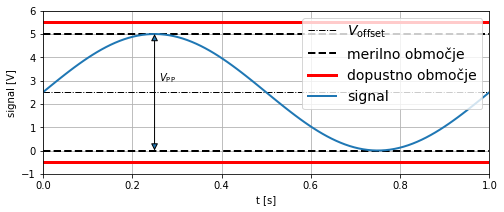

In [61]:
t = np.linspace(0, 1, 100)
signal = V_pp/2 * np.sin(2*np.pi*t) + V_offset

plt.figure(figsize=(8, 3))
plt.plot([0, 0], [0, 0], '-.', c='k', lw=1, label='$V_{\mathrm{offset}}$')
plt.plot([0, 0], [0, 0], '--', c='k', lw=2, label='merilno območje')
plt.plot([0, 0], [0, 0], c='r', lw=3, label='dopustno območje')
plt.axhline(y=V_offset, ls='-.', c='k', lw=1)
plt.axhline(y=0, c='k', ls='--', lw=2)
plt.axhline(y=5, c='k', ls='--', lw=2)
plt.axhline(y=-0.5, c='r', lw=3)
plt.axhline(y=5.5, c='r', lw=3)
plt.plot(t, signal, lw=2, label='signal')

plt.annotate("",
            xy=(0.25, 0), xycoords='data',
            xytext=(0.25, V_pp), textcoords='data',
            arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0,)
            )
plt.text(0.26, 3, '$V_{\mathrm{PP}}$', fontsize=14,)

plt.xlim(0, 1)
plt.ylim(-1, 6)
plt.xlabel('t [s]')
plt.ylabel('signal [V]')
plt.grid(True)
plt.legend(fontsize=14);

### LabView in Arduino

Paket LINX omogoča dostop do analognih vhodnih kanalov ter digitalnih I/O kanalov Arduino plošče iz LabView-a. Podpira tudi povezavo Arduina z zunanjimi napravami, na primer preko SPI ali I2C serijske povezave.

Do podprtih programskih elementov dostopamo preko posebnega menija v naboru funkcij blokovnega diagrama, `MakerHub -> LINX`.

![linx_functions](./images/02/makerhub_functions.png)

#### Povezava z Arduinom in prvi program

Za vzpostavitev povezave z Arduinom v LabView-u uporabimo posebno funkciji knjižnice LINX, `Open`. 

Osnovni parameter pri odpiranju povezave so *COM serijska vrata*, preko katerih je Arduino povezan na naš računalnik. Če je v sistem povezanih več podobnih serijskih naprav, lahko serijska vrata povezanega Arduina najdete z orodjem `Upravitelj naprav (Device Manager)`.

![device_manager](./images/02/device_manager_com.png)

Druga pomembna nastavitev je hitrost serijske povezave (*baud rate*) z Arduinom. Privzeta vrednsot je `9600`, najvišja, ki jo Arduino Uno dopušča, pa `115200`.

Po zaključenem delu z Arduinom v LabView programu moramo povezavo **zapreti s funkcijo `Close`**, sicer bomo pri ponovnem poskusu vzpostavitve povezave imeli težave! Programa zato **ne smemo nasilno prekiniti iz orodne vrstice LabView-a**!

![open_close](./images/02/00_open_close.png)

#### Avtomatizacija z Arduinom - digitalni I/O terminali

Čeprav Arduino vključuje relativno zmogljiv 10-bitni analogno-digitalni pretvornik s 6 analognimi vhodnimi kanali, zaradi relativno omejene procesorske moči *pogosto ni optimalna izbira za naprednejše aplikacije zajema signalov* (za potrebe tega predmeta pa so zmogljivosti Arduina seveda zadostne).

Bolj tipično področje uporabe je zato avtomatizacija in integracija različnih merilnih elementov in strojne opreme. To omogoča širok nabor večnamenskih digitalnih I/O terminalov (GPIO).

Poglejmo si osnovno uporabo GPIO kanalov Arduina, na primeru vklopa / izklopa LED luči, integrirane na Arduino plošči, katere stanje je povezano z vrednostjo GPIO terminala `13`.

![uno-led](./images/02/uno_led.png)

Za zapis `Boolean` vrednosti ustreznega GPIO terminala bomo uporabili funkcijo `Makerhub -> LINX -> Peripheral -> Digital -> Write`.

![digital-write](./images/02/digital_write.png)

```{admonition} Naloga 1
:class: seealso
Pripravimo LabView program, ki:
* vzpostavi povezavo z Arduinom na izbranih serijskih vratih,
* na digitalni terminal št. `13` zapiše izbrano `Boolean` vrednost,
* zapre povezavo z Arduinom.
```

![digital-out](./images/02/01_digital_out.png)

```{admonition} Naloga 2 (5 minut)
:class: important
Zgornji program nadgradite tako, da:
* omogoča nastavitev stanja LED luči (vklop / izklop) v realnem času,
* po zapisu stanja zgodovino stanj izrisuje na grafu.

Namig: na prejšnji vaji smo na grafu izrisovali numerične vrednosti, prebrano stanje digitalnega terminala pa je treba pred prikazom ustrezno pretvoriti!
```

## Zajem podatkov z Arduinom 

Pri zajemu podatkov gre običajno za pretvorbo merilnega signala (el. napetost) v digitalno obliko, ki poteka na D-A pretvorniku. Arduino Uno ima na voljo 6 analognih vhodov, ki so povezani za DAC komponento plošče.

Za pretvorbo in zajem posamezne točke signala na analognih vhodih lahko uporabimo funkcijo "AnalogRead" (``Makerhub -> LINX -> Peripheral -> Analog -> Read``), ki omogoča hkratni zajem na več kanalih hkrati.

```{note}
Vezje, ki ga bomo pri Procesiranju signalov uporabili skupaj z Arduinom za povezavo zunanjih signalov z analognimi vhodi plošče preko koaksialnih, BNC priključkov, omogoča uporabo analognih kanalov `A0` in `A1`.
```

![bnc_shield](./images/02/arduino_bnc_shield.png)

```{admonition} Naloga 3
:class: seealso
Pripravimo LabView program, ki:
* vzpostavi povezavo z Arduinom na izbranih serijskih vratih,
* v zanki zajeto nastavljeno število podatkov iz dveh analognih vhodnih kanalov izriše na graf.
```

![analog-read](./images/02/03_analog_read.png)

```{note}
Oblika podatkov, pridobljenih iz `N` kanalov pri nastavitvi v `n` iteracijah zanke, je `(n, N)` (torej `n` vrstic, `N` stolpcev).

Podatke, zajete na posameznem analognem kanalu, dobimo z izbiro posameznega stolpca (`col`) v dobljenem `array`-u, z uporabo `Arra -> Index Array` funkcije blokovnega diagrama.
```

```{note}
Ker so pridobljeni podatki po izbranem številu iteracij zanke zajema sedaj v obliki polja (`array`), za njihov prikaz uporabimo funkcijo "Waveform Graph" (`Graph -> Waveform Graph` na krmilni plošči).
```

```{admonition} Naloga 4 (10 minut)
:class: important
Zgornji program nadgradite tako, da:
* namesto trajanja pavze med zaporednimi iteracijami zajema omogoča izbiro *frekvence vzorčenja [Hz]*,
* omogoča izbiro izbranega števila zajetih segmentov signala z `n` vzorci,
* omogočja shranjevanje signala v `.lvm` datoteko.
```

Tako smo dobili enostaven sistem, ki ga že lahko uporabimo za zajem realnih merilnih signalov.

Zmogljivosti takega sistema so seveda omejene. Pri merjenju običajno želimo nadzorovati čimveč parametrov merilne opreme. Naslednji primer VI omogoča tudi določitev občutljivosti posamenzih merilnih kanalov ter shranjevanje neodvisne spremenljivke (časa) skupaj z zajetimi signali.

![open-loop-saving](./images/02/05_continuous_N_channels_open_loop_saving.png)

Naslednji primer pa omogoča tudi krmiljenje dejanjske frekvence vzorčenja v enostavni povratni zanki:

![closed-loop-saving](./images/02/07_continuous_N_channels_closed_loop_saving_new_feedback.png)

Pri tem je uporabljen tudi naslednji podprogram:

![closed-loop-saving-subvi](./images/02/07_01_clip_fs_SubVI.png)

## Python - branje in obdelava zajetih signalov

Pri branju podatkov, shranjnih v `.lvm` datoteke, si lahko pomagate s paketom [`lvm_read`](https://pypi.org/project/lvm-read/).

Primer uporabe si poglejmo spodaj.

In [21]:
import lvm_read
file = 'data/02/test_01.lvm'
loaded_data = lvm_read.read(file)
loaded_data.keys()

dict_keys(['Decimal_Separator', 'Writer_Version', 'Reader_Version', 'Separator', 'Multi_Headings', 'X_Columns', 'Time_Pref', 'Operator', 'Date', 'Time', 0, 'Segments'])

Naloženi podatki so strukturirani v obliki slovarja. Podatek `'Segments` nam pove, koliko segmentov smo zajeli:

In [23]:
loaded_data['Segments']

1

segment podatkov pa je v slovarju shranjen s ključem zaporednega indeksa. Če je shranjen segment samo eden, je edini indeks, ki je na voljo, `0`.

In [26]:
loaded_data[0].keys()

dict_keys(['Channels', 'Samples', 'Date', 'Time', 'X_Dimension', 'X0', 'Delta_X', 'data', 'Channel names'])

Vsak posameni segment je prav tako slovar, v katerem do surovih shranjenih podatkov dostopamo s ključem `'data'`:

In [27]:
loaded_data[0]['data'].shape

(100, 2)

Posamezni stolpci podatkov predstavljajo po en shranjen kanal:

In [28]:
kanal_1, kanal_2 = loaded_data[0]['data'].T

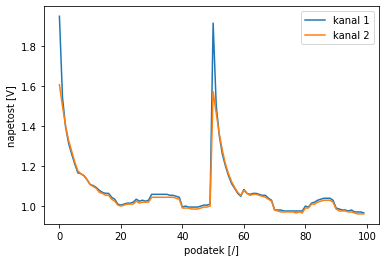

In [31]:
plt.figure()
plt.plot(kanal_1, label='kanal 1')
plt.plot(kanal_2, label='kanal 2')
plt.xlabel('podatek [/]')
plt.ylabel('napetost [V]')
plt.legend()

Poglejmo še primer, ko je v `.lvm` datoteki shranjenih več segmentov, ki so pri shranjevanju ločeni z glavami (*header*):

In [45]:
file_2 = 'data/02/test_segments.lvm'
loaded_data_2 = lvm_read.read(file_2)
loaded_data_2['Segments']

5

Po shranjenih segmentih lahko iteriramo:

In [46]:
all_segments = []

for seg in range(loaded_data_2['Segments']):
    all_segments.append(loaded_data_2[seg]['data'])

Datoteka v tem primeru vsebuje tudi stolpec neodvisne spremenljivke (časa):

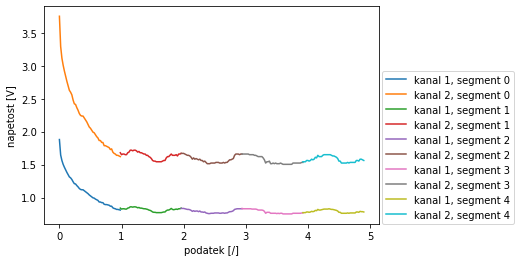

In [48]:

plt.figure()

t_start = 0
for i, segment in enumerate(all_segments):
    t, k1, k2 = segment.T
    t_segment = t + t_start
    t_start = t_segment[-1]
    plt.plot(t_segment, k1, label=f'kanal 1, segment {i}')
    plt.plot(t_segment, k2, label=f'kanal 2, segment {i}')

plt.xlabel('podatek [/]')
plt.ylabel('napetost [V]')
plt.legend(loc=(1.01, 0))

Lahko pa vse segmente združite (in poljubno obdelujete) z uporabo ustreznih Numpy funkcij:

In [51]:
complete_data = np.concatenate(all_segments)
complete_data.shape

(250, 3)

In [55]:
_, channel_1, channel_2 = complete_data.T
dt = _[1] - _[0]
t_complete = np.arange(len(channel_1)) * dt

<Figure size 432x288 with 0 Axes>

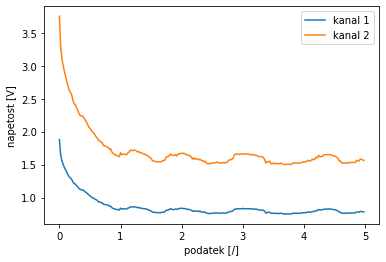

In [56]:
plt.figure()
plt.figure()
plt.plot(t_complete, channel_1, label='kanal 1')
plt.plot(t_complete, channel_2, label='kanal 2')
plt.xlabel('podatek [/]')
plt.ylabel('napetost [V]')
plt.legend()

## Domača naloga

```{admonition} Domača naloga
:class: warning
* Z uporabo prikazanih funkcij v LabView-u zajamite signal s predpisanimi parametri, pripravljen z uporabo generatorja signalov (individualizirane podatke najdete v [e-učilnici](https://e-ucilnica.fs.uni-lj.si/).
* Grafično predstavite "surove" podatke.
* Na zajetem signalu smiselno prikažite uporabo predpisaneih numeričnih podtopkov (`obdelava_#` v tabeli s podatki).

Pripravite kratko poročilo v okolju Jupyter Notebook *(od 3 do 10 celic s kodo)*, iz katerega naj bodo razvidni podatki nalge (iz tabele), ter da ste vse parametre pri izvedbi naloge tudi upoštevali (ustrezno izpišite obliko signala...). 
Poročilo oddajte tudi v `.pdf` obliki (glejte [navodila za oddajo domačih nalog](intro-domace-naloge)).

**Dodatek**: Raziščite in prikažite uporabo frekvenčnega filtriranja podatkov, katerega namen je odprava neželenega visokofrekvenčnega šuma v zajetem signalu (uporaite lahko  [`scipy.signal.lfilter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html)). Pred tem zajetemu signalu po potrebi dodajte aditivno naključno komponento (šum).
```

(02-uporaba-rigol)=
## Uporaba generatorja signalov (RIGOL DG1022)

Za simulacijo predpisane oblike periodičnega signala bomo uporabili generator signala.

Spodanja slika prikazuje nadzorno ploščo modela RIGOL DG1022.

![rigol-dg1022](./images/02/rigol_dg1022.png)

Za nastavitev izbranih parametrov signala uporabite kontrolne gumbe, na zgornji sliki označene z modro barvo. Pri tem bodite pozorni, da ste z gumbom `Channel Switch` izbrali kanal, na katerm želite oddajati signal.

Generator signala signal oddaja preko koaksialne (BNC) povezave na desni strani krmilne plošče. Oddajanje nastavljenega signala poteka, kadar je osvetljen `Output` gumb izbranega kanala.

![rigol-nastavitev](./images/02/rigol_nastavitev.png)

```{admonition} Opozorilo
:class: important
Preden vključite oddajanje signala z ustreznim `Channel` gumbom **preverite, da so vse nastavitve izbranega kanala pravilne, in da niste presegli merilnega območja zajemnega sistema**. Šele za tem priključite zajemni sistem na izhodni kanal generatorja signala!
```